In [1]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
import torch
print(torch.__version__)

0.3.1


In [2]:
# 31072 * 4 + 298424

# 422712

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt
from tqdm import tqdm_notebook, tqdm

In [4]:
PATH = './'
TRAIN = '../data/train_combined/'
TEST = '../data/test/'
LABELS = '../data/train_combined_all.csv'
SAMPLE = '../data/sample_submission.csv'

In [5]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [6]:
nw = 2   #number of workers for data loader
arch = resnet50 #specify target architecture

In [7]:
# train_names_png = list({f[:36] for f in os.listdir(TRAIN) if 'png' in f})
# train_names_jpg = []
# for f in tqdm_notebook(os.listdir(TRAIN)):
#     if 'png' in f:
#         continue
#     name = f.split('.')[0]
#     name = name.split('_')
#     if len(name) == 5:
#         name = name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]
#     else:
#         name = name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+name[4]
#     if name not in train_names_jpg:
#         train_names_jpg.append(name)

# train_names = train_names_png + train_names_jpg
# test_names = list({f[:36] for f in os.listdir(TEST)})


# tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [8]:
import pickle
with open('../cache/train_names', 'rb') as f:
    train_names = pickle.load(f)
print(len(train_names))
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

105678


In [9]:
# import pickle
# with open('../cache/train_names', 'wb') as f:
#     pickle.dump(train_names, f)
# with open('../cache/train_names_png1', 'wb') as f:
#     pickle.dump(train_names_png, f)
# with open('../cache/train_names_png2', 'wb') as f:
#     pickle.dump(train_names_jpg, f)

In [10]:
# len(train_names), len(train_names_jpg), len(train_names_png)
# (105678, 74606, 31072)

In [11]:
def open_rgby(path,id): #a function that reads RGBY image
#     colors = ['red','green','blue','yellow']
    colors = ['red','green','blue']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [12]:
# ??FilesDataset

In [13]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
#         print(fnames)
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [14]:
# ??tfms_from_stats
path_to_train = '../data/train_combined'
data = pd.read_csv('../data/train_combined_all.csv')

In [15]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
#     stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
#     stats = A([0.08069, 0.05258, 0.05487], [0.13704, 0.10145, 0.15313])
    stats = A([0.0751 , 0.05909, 0.04364], [0.11428, 0.09856, 0.09925])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [16]:
bs = 16
sz = 512
md = get_data(sz,bs)

In [17]:
# x_tot = np.zeros(3)
# x2_tot = np.zeros(3)
# for x,y in tqdm_notebook(iter(md.trn_dl)):
#     x = md.trn_ds.denorm(x).reshape(-1,3)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std
# (array([0.0751 , 0.05909, 0.04364]), array([0.11428, 0.09856, 0.09925]))

In [18]:
# mean = 0
# x2_tot = 0
# count = 0
# M2 = 0
# for name, labels in tqdm(zip(data['Id'], data['Target'].str.split(' '))):
#     if name not in tr_n:
#         continue
#     file = os.path.join(path_to_train, name)
#     image = load_image(file, (512, 512))/255.
#     val = np.reshape(image[:,:,0], -1)
#     img_mean = np.mean(val)
#     img_std = np.std(val)
#     count = count + 1
#     mean = mean + img_mean
#     M2 = M2 + img_std
#     x2_tot += np.mean(val**2)
# print('red mean', mean/(count))
# print('red std', M2/(count))
# channel_std = np.sqrt(x2_tot/count - ((mean/count)**2))

# 31072it [05:35, 92.74it/s]
# red mean 0.08052112660092407
# red std 0.13001299317356493

In [19]:
# x_tot = np.zeros(4)
# x2_tot = np.zeros(4)
# for x,y in iter(md.trn_dl):
# #     print(x.shape)
# #     tmp =  md.trn_ds.denorm(x).reshape(16,-1)
#     x = md.trn_ds.denorm(x).reshape(-1,4)
# #     print(x.shape)
# #     x = x.cpu().numpy().reshape(-1,4)
# #     print(x.shape)
#     x_tot += x.mean(axis=0)
#     x2_tot += (x**2).mean(axis=0)

# channel_avr = x_tot/len(md.trn_dl)
# channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
# channel_avr,channel_std

# (array([0.08702, 0.06006, 0.06512, 0.08925]),
#  array([0.14109, 0.1055 , 0.15163, 0.14201]))

In [20]:
# ??md.trn_ds.denorm

In [21]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [22]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [23]:
sz = 512 #image size
bs = 16  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = FocalLoss()
learner.metrics = [acc]

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

 65%|██████▌   | 3877/5944 [29:40<23:47,  1.45it/s, loss=4.83]

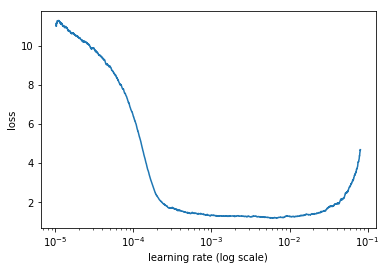

In [24]:
learner.lr_find()
learner.sched.plot()

In [25]:
lr = 8e-4
learner.fit(lr,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                           
    0      1.076604   1.008069   0.956445  


[array([1.00807]), 0.9564453336797277]

In [26]:
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [27]:
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                             
    0      0.753416   0.691114   0.969777  
    1      0.702316   0.651579   0.971369                        
    2      0.748814   0.654872   0.971254                        
    3      0.679828   0.622079   0.972511                        
    4      0.696075   0.637335   0.971883                        
    5      0.646604   0.613408   0.973045                        
    6      0.653173   0.625272   0.972508                        
    7      0.655555   0.601154   0.97338                         


[array([0.60115]), 0.9733798798514892]

In [28]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                             
    0      0.689312   0.627061   0.972528  
    1      0.633418   0.616619   0.973086                        
    2      0.620347   0.602689   0.973542                        
    3      0.5978     0.589879   0.974059                        
    4      0.64789    0.612528   0.972957                        
    5      0.610331   0.601921   0.973464                        
    6      0.583476   0.591609   0.973796                        
    7      0.579374   0.584113   0.974191                        


[array([0.58411]), 0.974190953371653]

In [29]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

epoch      trn_loss   val_loss   acc                             
    0      0.567063   0.586677   0.974252  
    1      0.587139   0.583313   0.974289                        
    2      0.564207   0.582343   0.974512                        
    3      0.564695   0.577199   0.974583                        
    4      0.566102   0.578606   0.974593                        
    5      0.549107   0.580369   0.97458                         
    6      0.555157   0.577438   0.974803                        
    7      0.565096   0.58107    0.974752                        


[array([0.58107]), 0.9747519463323265]

In [30]:
learner.save('ResNet50_512_50Max')

In [10]:
# ??learner.TTA

Object `learner.TTA` not found.


In [27]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [31]:


preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [32]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [33]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/home/watts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [0.54629 0.50232 0.51148 0.50899 0.53346 0.55995 0.55026 0.53009 0.68062 0.62436 0.57881 0.57268 0.57476
 0.49415 0.53886 0.34376 0.57524 0.57835 0.47421 0.504   0.56678 0.48903 0.45607 0.56216 0.59767 0.49692
 0.47134 0.31459]
F1 macro:  0.6391818926242518
F1 macro (th = 0.5):  0.6069224394970286
F1 micro:  0.7615527950310559


In [34]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [58]:
np.save('../cache/preds_t_50_max', preds_t)

In [24]:
learner.load('ResNet50_512_50Max')

In [67]:
preds_t, y_t= learner.predict_with_targs(is_test=True)

In [68]:
preds_t.shape

(11702, 28)

In [69]:
preds1_t = preds_t

In [70]:
preds_t[0]

array([ 1.05024, -3.77126, -2.67847, -2.95024, -3.37264, -1.93405, -3.13763, -1.96297, -6.17354, -5.69437,
       -5.95168, -2.63831, -3.56306, -3.58782, -3.22382, -5.7628 , -2.17251, -2.68878, -2.66358, -0.92524,
       -3.93674, -1.91435, -2.77443, -3.0279 , -3.21317, -0.46304, -3.23608, -4.84881], dtype=float32)

In [71]:
# preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [72]:
preds_t[0]

array([0.74082, 0.0225 , 0.06426, 0.04972, 0.03316, 0.1263 , 0.04158, 0.12315, 0.00208, 0.00335, 0.00259,
       0.06671, 0.02757, 0.02691, 0.03828, 0.00313, 0.10225, 0.06364, 0.06516, 0.28389, 0.01914, 0.12849,
       0.05872, 0.04618, 0.03867, 0.38627, 0.03783, 0.00778], dtype=float32)

In [73]:
np.save('../cache/preds_t_noTTA_50_max', preds_t)

In [35]:
def save_pred(pred, th=0.5, fname='../submissions/sub50-max.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [36]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

Fractions:  [0.43565 0.04991 0.07913 0.077   0.08366 0.12451 0.07349 0.1087  0.00111 0.00111 0.0012  0.05315 0.0429
 0.02495 0.04794 0.      0.06486 0.04367 0.04298 0.0787  0.01222 0.15485 0.0411  0.11784 0.01453 0.28337
 0.03863 0.0435 ]


In [37]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]

In [38]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [39]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.63296 0.46181 0.57307 0.40913 0.3563  0.49311 0.42073 0.552   0.1459  0.16103 0.1546  0.49037 0.3116
 0.54685 0.54292 0.15627 0.5857  0.77269 0.52832 0.46315 0.43512 0.5528  0.45369 0.60869 0.5605  0.59079
 0.37693 0.17616]
Fractions:  [0.36498 0.0435  0.07426 0.05854 0.07289 0.07375 0.04256 0.07443 0.00701 0.00786 0.00735 0.04358 0.04247
 0.01427 0.04392 0.00641 0.02897 0.01427 0.02854 0.05854 0.00974 0.12494 0.02794 0.07494 0.01    0.22193
 0.02777 0.00573]
Fractions (th = 0.5):  [0.49821 0.04127 0.09092 0.04444 0.04247 0.07195 0.02777 0.0899  0.00068 0.00068 0.00051 0.0423  0.02094
 0.01564 0.04683 0.      0.03888 0.03521 0.03341 0.04905 0.00769 0.15775 0.0235  0.10716 0.01145 0.34498
 0.01547 0.00026]


In [40]:
save_pred(pred_t,th_t,'../submissions/sub50-max-f.csv')

In [41]:
save_pred(pred_t,th,'../submissions/sub50-max-v.csv')
save_pred(pred_t,0.5,'../submissions/sub50-max-05.csv')

In [56]:
# save_pred(pred_t,0.5,'../submissions/sub50-max-05.csv')
save_pred(pred_t,0.45,'../submissions/sub50-max-045.csv')
save_pred(pred_t,0.40,'../submissions/sub50-max-040.csv')
save_pred(pred_t,0.35,'../submissions/sub50-max-035.csv')
save_pred(pred_t,0.30,'../submissions/sub50-max-030.csv')
save_pred(pred_t,0.25,'../submissions/sub50-max-025.csv')

In [42]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'../submissions/sub50-max-c.csv')

In [43]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([40958.,  3072., 10871.,  3329.,  5130.,  5938.,  3725.,  9405.,   217.,   197.,   182.,  2194.,
         2233.,  1458.,  2692.,    63.,  1290.,   446.,  1893.,  3672.,   438., 13809.,  2729., 10345.,
          428., 37366.,   706.,   127.]),
 array([0.38757, 0.02907, 0.10287, 0.0315 , 0.04854, 0.05619, 0.03525, 0.089  , 0.00205, 0.00186, 0.00172,
        0.02076, 0.02113, 0.0138 , 0.02547, 0.0006 , 0.01221, 0.00422, 0.01791, 0.03475, 0.00414, 0.13067,
        0.02582, 0.09789, 0.00405, 0.35358, 0.00668, 0.0012 ]))

In [44]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'../submissions/sub50-max-t.csv')

Thresholds:  [0.61031 0.69905 0.46599 0.605   0.46466 0.55995 0.45961 0.50596 0.28119 0.32072 0.30641 0.76949 0.50039
 0.5588  0.77093 0.28936 0.79564 0.93314 0.60171 0.57444 0.62792 0.54489 0.4801  0.52909 0.8591  0.4939
 0.66123 0.28138]
Fractions:  [0.38908 0.02931 0.10195 0.03145 0.04794 0.0564  0.03401 0.08793 0.00197 0.00162 0.00171 0.02119 0.02094
 0.01367 0.02555 0.0006  0.01222 0.00419 0.01743 0.03427 0.00436 0.12938 0.02504 0.09674 0.00419 0.35267
 0.00641 0.00085]


In [45]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-t.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 468k/468k [00:18<00:00, 25.5kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName          date                 description  status    publicScore  privateScore  
----------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-t.csv   2018-12-14 02:56:13               complete  0.507        None          
sub48-max-b.csv   2018-12-12 06:57:44               complete  0.449        None          
sub48-max-a.csv   2018-12-12 06:55:45               complete  0.457        None          
sub44-max-t.csv   2018-12-10 20:51:55               complete  0.019        None          
sub41-t-l.csv     2018-12-08 09:27:37               complete  0.541        None          
sub41-max-b.csv   2018-12-08 08:04:32               complete  0.478        None          
sub41-max-a.csv   2018-12-08 08:03:03               complete  0.479        None          
sub41-c.csv       2018-12-07 01:29:14      

In [46]:
leak_test = pd.read_csv('../cache/leak_test.csv')
sub50 = pd.read_csv('../submissions/sub50-max-t.csv')
for idx, row in leak_test.iterrows():
    test_id = row['Id']
    target = row['Target']
    sub50.loc[sub50.Id == test_id, 'Predicted'] = target

In [47]:
sub50.to_csv('../submissions/sub50-max-t-l.csv', index=False)

In [48]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-t-l.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 468k/468k [00:15<00:00, 30.7kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName           date                 description  status    publicScore  privateScore  
-----------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-t-l.csv  2018-12-14 04:48:42               complete  0.533        None          
sub50-max-t.csv    2018-12-14 02:56:13               complete  0.507        None          
sub48-max-b.csv    2018-12-12 06:57:44               complete  0.449        None          
sub48-max-a.csv    2018-12-12 06:55:45               complete  0.457        None          
sub44-max-t.csv    2018-12-10 20:51:55               complete  0.019        None          
sub41-t-l.csv      2018-12-08 09:27:37               complete  0.541        None          
sub41-max-b.csv    2018-12-08 08:04:32               complete  0.478        None          
sub41-max-a.csv    2018-12-08 08:0

In [49]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-c.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 468k/468k [00:08<00:00, 49.1kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName           date                 description  status    publicScore  privateScore  
-----------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-c.csv    2018-12-14 04:52:04               complete  0.523        None          
sub50-max-t-l.csv  2018-12-14 04:48:42               complete  0.533        None          
sub50-max-t.csv    2018-12-14 02:56:13               complete  0.507        None          
sub48-max-b.csv    2018-12-12 06:57:44               complete  0.449        None          
sub48-max-a.csv    2018-12-12 06:55:45               complete  0.457        None          
sub44-max-t.csv    2018-12-10 20:51:55               complete  0.019        None          
sub41-t-l.csv      2018-12-08 09:27:37               complete  0.541        None          
sub41-max-b.csv    2018-12-08 08:0

In [53]:
leak_test = pd.read_csv('../cache/leak_test.csv')
sub50 = pd.read_csv('../submissions/sub50-max-c.csv')
for idx, row in leak_test.iterrows():
    test_id = row['Id']
    target = row['Target']
    sub50.loc[sub50.Id == test_id, 'Predicted'] = target
sub50.to_csv('../submissions/sub50-max-c-l.csv', index=False)

In [54]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-c-l.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName           date                 description  status    publicScore  privateScore  
-----------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-c-l.csv  2018-12-14 04:52:55               complete  0.557        None          
sub50-max-c.csv    2018-12-14 04:52:04               complete  0.523        None          
sub50-max-t-l.csv  2018-12-14 04:48:42               complete  0.533        None          
sub50-max-t.csv    2018-12-14 02:56:13               complete  0.507        None          
sub48-max-b.csv    2018-12-12 06:57:44               complete  0.449        None          
sub48-max-a.csv    2018-12-12 06:55:45               complete  0.457        None          
sub44-max-t.csv    2018-12-10 20:51:55               complete  0.019        None          
sub41-t-l.csv      2018-12-08 09:27:37               complete  0.541        None          
sub41-max-b.csv    2018-12-08 08:04:32               complete  0.478        None          

In [55]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-05.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 476k/476k [00:13<00:00, 37.1kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName           date                 description  status    publicScore  privateScore  
-----------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-05.csv   2018-12-14 04:56:42               complete  0.533        None          
sub50-max-c-l.csv  2018-12-14 04:52:55               complete  0.557        None          
sub50-max-c.csv    2018-12-14 04:52:04               complete  0.523        None          
sub50-max-t-l.csv  2018-12-14 04:48:42               complete  0.533        None          
sub50-max-t.csv    2018-12-14 02:56:13               complete  0.507        None          
sub48-max-b.csv    2018-12-12 06:57:44               complete  0.449        None          
sub48-max-a.csv    2018-12-12 06:55:45               complete  0.457        None          
sub44-max-t.csv    2018-12-10 20:5

In [6]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-045.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName           date                 description  status    publicScore  privateScore  
-----------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-045.csv  2018-12-15 05:36:27               complete  0.528        None          
sub50-max-05.csv   2018-12-14 04:56:42               complete  0.533        None          
sub50-max-c-l.csv  2018-12-14 04:52:55               complete  0.557        None          
sub50-max-c.csv    2018-12-14 04:52:04               complete  0.523        None          
sub50-max-t-l.csv  2018-12-14 04:48:42               complete  0.533        None          
sub50-max-t.csv    2018-12-14 02:56:13               complete  0.507        None          
sub48-max-b.csv    2018-12-12 06:57:44               complete  0.449        None          
sub48-max-a.csv    2018-12-12 06:55:45               complete  0.457        None          
sub44-max-t.csv    2018-12-10 20:51:55               complete  0.019        None          

In [7]:
leak_test = pd.read_csv('../cache/leak_test.csv')
sub50 = pd.read_csv('../submissions/sub50-max-05.csv')
for idx, row in leak_test.iterrows():
    test_id = row['Id']
    target = row['Target']
    sub50.loc[sub50.Id == test_id, 'Predicted'] = target
sub50.to_csv('../submissions/sub50-max-05-l.csv', index=False)

In [9]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-05-l.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 476k/476k [00:44<00:00, 10.8kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName            date                 description  status    publicScore  privateScore  
------------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-05-l.csv  2018-12-15 05:44:54               complete  0.578        None          
sub50-max-045.csv   2018-12-15 05:36:27               complete  0.528        None          
sub50-max-05.csv    2018-12-14 04:56:42               complete  0.533        None          
sub50-max-c-l.csv   2018-12-14 04:52:55               complete  0.557        None          
sub50-max-c.csv     2018-12-14 04:52:04               complete  0.523        None          
sub50-max-t-l.csv   2018-12-14 04:48:42               complete  0.533        None          
sub50-max-t.csv     2018-12-14 02:56:13               complete  0.507        None          
sub48-max-b.csv     2018-

In [75]:
def save_pred(pred, th=0.5, fname='../submissions/sub50-max-notta.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [76]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

ValueError: operands could not be broadcast together with shapes (11702,) (28,) 

In [60]:
# pred= preds_t
# fname='../submissions/sub50-max-notta.csv'
# th=0.5
# pred_list = []
# for line in pred:
#     s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
#     pred_list.append(s)
# sample_df = pd.read_csv(SAMPLE)
# sample_list = list(sample_df.Id)
# pred_dic = dict((key, value) for (key, value) 
#             in zip(learner.data.test_ds.fnames,pred_list))
# pred_list_cor = [pred_dic[id] for id in sample_list]
# df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
# df.to_csv(fname, header=True, index=False)

In [61]:
df.shape

(11702, 2)

In [62]:
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23


In [80]:
save_pred(pred_t,0.5,'../submissions/sub50-max-05-notta.csv')

In [84]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-05-notta.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-05-notta.csv  2018-12-15 08:41:36               complete  0.020        None          
sub50-max-05-notta.csv  2018-12-15 08:22:48               complete  0.020        None          
sub54-max-a.csv         2018-12-15 06:06:02               complete  0.365        None          
sub50-max-05-l.csv      2018-12-15 05:44:54               complete  0.578        None          
sub50-max-045.csv       2018-12-15 05:36:27               complete  0.528        None          
sub50-max-05.csv        2018-12-14 04:56:42               complete  0.533        None          
sub50-max-c-l.csv       2018-12-14 04:52:55               complete  0.557        None          
sub50-max-c.csv         2018-12-14 04:52:04               complete  0.523        None          
sub50-max-t-l.csv       2018-12-14 04:48

In [9]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50_22.csv -m ""
from time import sleep
sleep(30)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 476k/476k [00:12<00:00, 37.6kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub50_22.csv            2018-12-16 02:56:59               complete  0.579        None          
sub50_22.csv            2018-12-16 02:32:16               complete  0.578        None          
sub50_22.csv            2018-12-16 02:16:49               complete  0.059        None          
sub50_22.csv            2018-12-16 02:00:57               complete  0.059        None          
sub50-max-05-notta.csv  2018-12-15 08:41:36               complete  0.020        None          
sub50-max-05-notta.csv  2018-12-15 08:22:48               complete  0.020        None          
sub54-max-a.csv         2018-12-15 06:06:02               complete  0.365        None

In [11]:
# !pip install imagehash

In [32]:
import pickle
import numpy as np
from imagehash import phash
from math import sqrt

def match(h1,h2, h2ps, color):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 =  pil_image.open(expand_path(p1) + '_' + color + '.png')
            i2 =  pil_image.open(expand_path(p2) + '_' + color + '.png')
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1/sqrt((a1**2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2/sqrt((a2**2).mean())
            a  = ((a1 - a2)**2).mean()
            if a > 0.1: return False
    return True

In [20]:
tagged = dict([(p,w) for _,p,w in pd.read_csv('../data/train_combined_all.csv').to_records()])
submit = [p for _,p,_ in pd.read_csv('../data/sample_submission.csv').to_records()]
join   = list(tagged.keys()) + submit
len(tagged),len(submit),len(join),list(tagged.items())[:5],submit[:5]


(105678,
 11702,
 117380,
 [('00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', '16 0'),
  ('000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', '7 1 2 0'),
  ('000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', '5'),
  ('000c99ba-bba4-11e8-b2b9-ac1f6b6435d0', '1'),
  ('001838f8-bbca-11e8-b2bc-ac1f6b6435d0', '18')],
 ['00008af0-bad0-11e8-b2b8-ac1f6b6435d0',
  '0000a892-bacf-11e8-b2b8-ac1f6b6435d0',
  '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0',
  '0008baca-bad7-11e8-b2b9-ac1f6b6435d0',
  '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0'])

In [21]:
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

In [22]:
def expand_path(p):
    if isfile('../data/train_combined/' + p + '_green.png'): return '../data/train_combined/' + p
    if isfile('../data/test/' + p + '_green.png'): return '../data/test/' + p
    return p

In [25]:
p2h_red = {}
p2h_green = {}
p2h_blue = {}
for p in tqdm_notebook(join):
    img1    = pil_image.open(expand_path(p) + '_red.png')
    img2    = pil_image.open(expand_path(p) + '_green.png')
    img3    = pil_image.open(expand_path(p) + '_blue.png')
    
    h1      = phash(img1)
    p2h_red[p] = h1

    h2      = phash(img2)
    p2h_green[p] = h2
    
    h3      = phash(img3)
    p2h_blue[p] = h3

HBox(children=(IntProgress(value=0, max=117380), HTML(value='')))

In [26]:
# Find all images associated with a given phash value.
h2ps_red = {}
for p,h in tqdm_notebook(p2h_red.items()):
    if h not in h2ps_red: h2ps_red[h] = []
    if p not in h2ps_red[h]: h2ps_red[h].append(p)

# Find all distinct phash values
hs_red = list(h2ps_red.keys())

HBox(children=(IntProgress(value=0, max=117380), HTML(value='')))

In [27]:
h2ps_green = {}
for p,h in tqdm_notebook(p2h_green.items()):
    if h not in h2ps_green: h2ps_green[h] = []
    if p not in h2ps_green[h]: h2ps_green[h].append(p)

# Find all distinct phash values
hs_green = list(h2ps_green.keys())

HBox(children=(IntProgress(value=0, max=117380), HTML(value='')))

In [28]:
h2ps_blue= {}
for p,h in tqdm_notebook(p2h_blue.items()):
    if h not in h2ps_blue: h2ps_blue[h] = []
    if p not in h2ps_blue[h]: h2ps_blue[h].append(p)

# Find all distinct phash values
hs_blue = list(h2ps_blue.keys())

HBox(children=(IntProgress(value=0, max=117380), HTML(value='')))

In [ ]:
# If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
h2h_red = {}
for i,h1 in enumerate(tqdm_notebook(hs_red)):
    for h2 in hs_red[:i]:
        if h1-h2 <= 6 and match(h1, h2, h2ps_red, 'red'):
            s1 = str(h1)
            s2 = str(h2)
            if s1 < s2: s1,s2 = s2,s1
            h2h_red[s1] = s2

HBox(children=(IntProgress(value=0, max=113281), HTML(value='')))

In [ ]:
# If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
h2h_green = {}
for i,h1 in enumerate(tqdm_notebook(hs_green)):
    for h2 in hs_green[:i]:
        if h1-h2 <= 6 and match(h1, h2, h2ps_green, 'green'):
            s1 = str(h1)
            s2 = str(h2)
            if s1 < s2: s1,s2 = s2,s1
            h2h_green[s1] = s2

HBox(children=(IntProgress(value=0, max=113063), HTML(value='')))

In [ ]:
# If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
h2h_blue = {}
for i,h1 in enumerate(tqdm_notebook(hs_blue)):
    for h2 in hs_blue[:i]:
        if h1-h2 <= 6 and match(h1, h2, h2ps_blue, 'blue'):
            s1 = str(h1)
            s2 = str(h2)
            if s1 < s2: s1,s2 = s2,s1
            h2h_blue[s1] = s2

In [ ]:
# Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
for p,h in tqdm_notebook(p2h_red.items()):
    h = str(h)
    if h in h2h_red: h = h2h_red[h]
    p2h_red[p] = h

len(p2h_red), list(p2h_red.items())[:5]

In [ ]:
# Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
for p,h in tqdm_notebook(p2h_green.items()):
    h = str(h)
    if h in h2h_green: h = h2h_green[h]
    p2h_green[p] = h

len(p2h_green), list(p2h_green.items())[:5]

In [ ]:
# Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
for p,h in tqdm_notebook(p2h_blue.items()):
    h = str(h)
    if h in h2h_blue: h = h2h_blue[h]
    p2h_blue[p] = h

len(p2h_blue), list(p2h_blue.items())[:5]

In [24]:
learner.load('ResNet50_512_50Max')

In [26]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

In [27]:
preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [28]:
pred.shape

(10568, 28)

In [32]:
preds_y = pred
valid_y = y

In [33]:
thresholds = np.linspace(0, 1, 1000)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        max_val = np.max(preds_y)
        val_predict = (preds_y > test_threshold)
        score = f1_score(valid_y > 0.5, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]

print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)

/home/watts/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[0] 0.564565, F1: 0.613524
Threshold[1] 0.578579, F1: 0.613827
Threshold[2] 0.522523, F1: 0.613947
Threshold[3] 0.508509, F1: 0.614109
Threshold[4] 0.556557, F1: 0.614303
Threshold[5] 0.546547, F1: 0.614791
Threshold[6] 0.549550, F1: 0.615562
Threshold[7] 0.524525, F1: 0.615918
Threshold[8] 0.671672, F1: 0.619461
Threshold[9] 0.630631, F1: 0.627703
Threshold[10] 0.576577, F1: 0.634138
Threshold[11] 0.568569, F1: 0.634515
Threshold[12] 0.597598, F1: 0.634666
Threshold[13] 0.494494, F1: 0.634779
Threshold[14] 0.540541, F1: 0.635516
Threshold[15] 0.269269, F1: 0.644063
Threshold[16] 0.604605, F1: 0.644882
Threshold[17] 0.609610, F1: 0.647033
Threshold[18] 0.498498, F1: 0.647138
Threshold[19] 0.525526, F1: 0.647413
Threshold[20] 0.568569, F1: 0.649028
Threshold[21] 0.483483, F1: 0.649145
Threshold[22] 0.477477, F1: 0.649667
Threshold[23] 0.543544, F1: 0.649885
Threshold[24] 0.609610, F1: 0.650996
Threshold[25] 0.506507, F1: 0.651021
Threshold[26] 0.491491, F1: 0.651435
Threshold[2

In [49]:
# preds_t = np.load('../cache/preds_t_50_max.npy')

In [36]:
def save_pred(pred, th=0.5, fname='../submissions/sub50-max.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [50]:
# preds_t = np.stack(preds_t, axis=-1)
# preds_t = sigmoid_np(preds_t)
# pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [52]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [53]:
pred_t.shape

(11702, 28)

In [54]:
th_t = np.array([0.56456, 0.57858, 0.52252, 0.50851, 0.55656, 0.54655, 0.54955, 0.52452, 0.67167, 0.63063,
                 0.57658, 0.56857, 0.5976, 0.49449, 0.54054, 0.26927, 0.6046, 0.60961, 0.4985,  
                 0.52553, 0.56857, 0.48348, 0.47748, 0.54354, 0.60961, 0.50651, 0.49149, 0.28128])
save_pred(pred_t,th_t,'../submissions/sub50-max-f-1.csv')

In [55]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-f-1.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 472k/472k [02:07<00:00, 3.79kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-f-1.csv       2018-12-18 16:38:26               complete  0.525        None          
sub50-max-f-1.csv       2018-12-18 15:53:31               complete  0.061        None          
sub55-max-045-l.csv     2018-12-17 20:34:48               complete  0.574        None          
sub55-max-05-l.csv      2018-12-17 20:32:23               complete  0.581        None          
sub55-max-045.csv       2018-12-17 20:31:53               complete  0.567        None          
sub55-max-05.csv        2018-12-17 20:31:18               complete  0.559        None          
sub55-max-05.csv        2018-12-17 20:30:37               complete  0.559        None

In [56]:
leak_test = pd.read_csv('../cache/leak_test.csv')
sub50 = pd.read_csv('../submissions/sub50-max-f-1.csv')
for idx, row in leak_test.iterrows():
    test_id = row['Id']
    target = row['Target']
    sub50.loc[sub50.Id == test_id, 'Predicted'] = target
sub50.to_csv('../submissions/sub50-max-f-1-l.csv', index=False)

In [57]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-f-1-l.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 472k/472k [00:41<00:00, 11.7kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-f-1-l.csv     2018-12-18 16:40:56               complete  0.546        None          
sub50-max-f-1.csv       2018-12-18 16:38:26               complete  0.525        None          
sub50-max-f-1.csv       2018-12-18 15:53:31               complete  0.061        None          
sub55-max-045-l.csv     2018-12-17 20:34:48               complete  0.574        None          
sub55-max-05-l.csv      2018-12-17 20:32:23               complete  0.581        None          
sub55-max-045.csv       2018-12-17 20:31:53               complete  0.567        None          
sub55-max-05.csv        2018-12-17 20:31:18               complete  0.559        None

In [58]:
y_t.shape

(11702, 28)

In [59]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-f.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 469k/469k [00:13<00:00, 36.8kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-f.csv         2018-12-18 20:15:51               complete  0.513        None          
sub50-max-f-1-l.csv     2018-12-18 16:40:56               complete  0.546        None          
sub50-max-f-1.csv       2018-12-18 16:38:26               complete  0.525        None          
sub50-max-f-1.csv       2018-12-18 15:53:31               complete  0.061        None          
sub55-max-045-l.csv     2018-12-17 20:34:48               complete  0.574        None          
sub55-max-05-l.csv      2018-12-17 20:32:23               complete  0.581        None          
sub55-max-045.csv       2018-12-17 20:31:53               complete  0.567        None

In [60]:
save_pred(pred_t,0.55,'../submissions/sub50-max-055.csv')

In [61]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub50-max-055.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 468k/468k [00:13<00:00, 36.3kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName                date                 description  status    publicScore  privateScore  
----------------------  -------------------  -----------  --------  -----------  ------------  
sub50-max-055.csv       2018-12-18 20:29:16               complete  0.510        None          
sub50-max-f.csv         2018-12-18 20:15:51               complete  0.513        None          
sub50-max-f-1-l.csv     2018-12-18 16:40:56               complete  0.546        None          
sub50-max-f-1.csv       2018-12-18 16:38:26               complete  0.525        None          
sub50-max-f-1.csv       2018-12-18 15:53:31               complete  0.061        None          
sub55-max-045-l.csv     2018-12-17 20:34:48               complete  0.574        None          
sub55-max-05-l.csv      2018-12-17 20:32:23               complete  0.581        None

In [62]:
int('f', 16)

15